In [1]:
import os 
import h5py
import numpy as np 
import astropy.units as u
# --- desihub --- 
import desisim.simexp
import specsim.instrument

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# Read in reference sky brightness

In [3]:
wave_ref, Isky_ref = np.load('/global/cfs/cdirs/desi/users/chahah/BGS_reference_sky_brightness.20210210.npy')

# Read Noise contribution for Reference Exposure
Lets see if read noise makes a significant contribution to the noise for reference exposure with $t_{\rm ref} = 280s$

In [4]:
# Generate specsim config object for a given wavelength grid
config = desisim.simexp._specsim_config_for_wave(wave_ref, dwave_out=0.8, specsim_config_file='desi')

In [5]:
instrument = specsim.instrument.initialize(config, True)

In [6]:
plate_scale = config.load_table(config.instrument.plate_scale, ['radius', 'radial_scale', 'azimuthal_scale'], interpolate=False)
radial_fiber_size = (0.5 * instrument.fiber_diameter / instrument.radial_scale(plate_scale['radius']))
azimuthal_fiber_size = (0.5 * instrument.fiber_diameter / instrument.azimuthal_scale(plate_scale['radius']))

desi_fiber_area = np.mean(np.pi*radial_fiber_size * azimuthal_fiber_size)
print('mean fiber area %f' % desi_fiber_area.value)

mean fiber area 1.862089


In [7]:
ref_texp = 280 * u.s

ref_sky_fibflux = (Isky_ref * 1e-17 * u.erg/u.Angstrom/u.s/u.cm**2/u.arcsec**2) * desi_fiber_area 
ref_sky_photon = ref_sky_fibflux.to(u.erg/u.Angstrom/u.s/u.cm**2) * instrument.photons_per_bin * ref_texp

ref_waves, ref_sky_electrons, ref_dark_electrons, read_noise_electrons = [], [], [], [] 
for camera in instrument.cameras: 
    ref_sky_electron = camera.downsample(camera.apply_resolution(ref_sky_photon * camera.throughput))
    ref_dark_electron = camera.downsample((camera.dark_current_per_bin * ref_texp).to(u.electron).value)
    read_noise_electron = camera.downsample(camera.read_noise_per_bin.to(u.electron).value)

    ref_waves.append(camera.output_wavelength.value)
    ref_sky_electrons.append(ref_sky_electron)
    ref_dark_electrons.append(ref_dark_electron)
    read_noise_electrons.append(read_noise_electron**2)

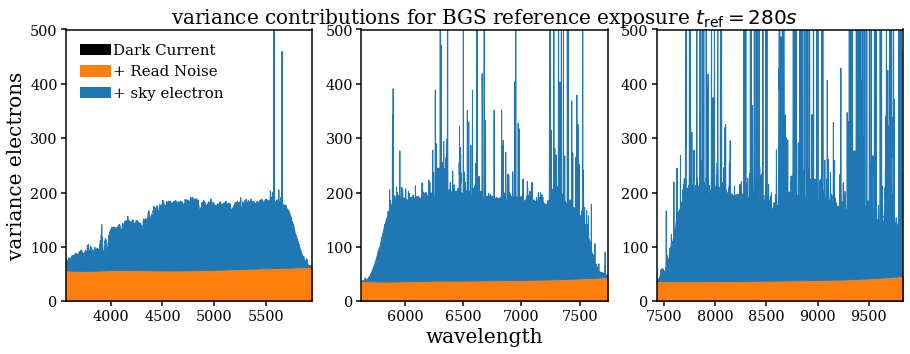

In [8]:
fig = plt.figure(figsize=(15,5))
for i in range(3): 
    sub = fig.add_subplot(1,3,i+1)
    sub.fill_between(ref_waves[i], np.zeros(len(ref_waves[i])), ref_dark_electrons[i], color='k', label='Dark Current')
    sub.fill_between(ref_waves[i], ref_dark_electrons[i], ref_dark_electrons[i] + read_noise_electrons[i], color='C1', label='+ Read Noise')
    sub.fill_between(ref_waves[i], ref_dark_electrons[i] + read_noise_electrons[i], ref_dark_electrons[i] + read_noise_electrons[i] + ref_sky_electrons[i], color='C0', label='+ sky electron')    
    if i == 1: 
        sub.set_xlabel('wavelength', fontsize=20)
        sub.set_title(r'variance contributions for BGS reference exposure $t_{\rm ref} = 280s$', fontsize=20)
    sub.set_xlim(ref_waves[i].min(), ref_waves[i].max())
    if i == 0: 
        sub.set_ylabel('variance electrons', fontsize=20)
        sub.legend(loc='upper left', fontsize=15, handletextpad=0.2)
    sub.set_ylim(0., 500)

### The noise is dominated by sky noise, but read noise has a non-negligible contribution.